
In this notebook supervised learning techniques are used to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the raw data. Like images they haave numeric values. Here they are floats, thus the features are a vector 3072 floats. The spectra are normalized by fitting a linear function to a range which is does not have strong features. 

In [1]:
#basic libraries
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight



#Astrop.io is needed to read the files with the astronomical features. 
from astropy.io import fits

Below we load the feature data and construct the labels used here of general labels. There are three classes here. Two classes early and late are for different types of stars. Both types show clear intrinsic variability. In addition there is real noise. This noise is mainly responsible that some spectra are not classified. They are unclassified. This third class is therefore even more diverse. Early and unclassfied are rather rare classes. Two datasets are combined into one here to have larger numbers of the rare classes. 

In [2]:
#General labels of data set A
vel=np.loadtxt('./finvel_exp_st_v2_combined.txt').T
print(f"shape of targets: {np.shape(vel)}")
colnames=['spec_quality','v_los','ev_fullcorr','ev_specparts','early','ev_final','corr_max','s/n','id_exposure','id_ifu','id_cube','cub_quality','class']
print(f"General labels of data set A {colnames}")
#The features are in the fits data cubes below, the ids above connect them with labels
#id_cube is for which cube to use, the others for the location in it. 
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
hbin=fits.open(path+'st1_atm_norm_cont_corr.fits.gz')
spec1n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st2_atm_norm_cont_corr.fits.gz')
spec2n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st3_atm_norm_cont_corr.fits.gz')
spec3n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st4_atm_norm_cont_corr.fits.gz')
spec4n=hbin[0].data
hbin.close()
print(f"shape of feature cubes: {np.shape(spec4n)}")
#select the stars with spectra, and creates the class used
m=int(np.shape(vel)[0]+1)
print(f"number of genral labels {m}")
#Make large file for label combining the two datasets 
velg=np.zeros((int((np.shape(vel)[0])+1),4500))
#Spectra are but in a two 
x=np.zeros((3072,4500))
#counters to count the  number of each type of spectrum
cg=0
ce=0
cl=0
for i in range(np.shape(vel)[1]):
    #exclude the really bad columns
    if  vel[11,i]>-0.5:
        if vel[10,i]==1 and np.median(spec1n[:,int(vel[9,i]-1),int(vel[8,i]-1)])>0:
            x[:,cg]=spec1n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            velg[0:12,cg]=vel[:,i]
            cg+=1
        if vel[10,i]==2 and np.median(spec2n[:,int(vel[9,i]-1),int(vel[8,i]-1)])>0:
            x[:,cg]=spec2n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            velg[0:12,cg]=vel[:,i]
            cg+=1
        if vel[10,i]==3 and np.median(spec3n[:,int(vel[9,i]-1),int(vel[8,i]-1)])>0:
            x[:,cg]=spec3n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            velg[0:12,cg]=vel[:,i]
            cg+=1
        if vel[10,i]==4 and np.median(spec4n[:,int(vel[9,i]-1),int(vel[8,i]-1)])>0:
            x[:,cg]=spec4n[:,int(vel[9,i]-1),int(vel[8,i]-1)]   
            velg[0:12,cg]=vel[:,i]
            cg+=1
        #creating the labels used, the thitrd is unclassified stays zeros    
        if velg[0,cg-1]>0:
            velg[12,cg-1]=1  #are late type
            cl+=1
        if velg[0,cg-1]<=0 and velg[4,cg-1]==1:
            velg[12,cg-1]=2      #are early type   
            ce+=1
print(f"After inclusion of data set A")            
print(f"number of sources: {cg} ")
print(f"number of unclassified sources: {cg-cl-ce} ")
print(f"number of late-type sources: {cl} ")
print(f"number of sources with spectra: {ce} ")

#now adding from spectra from 2018 data set B, same spectra for features
path='/home/tobias/ml-testing/spectra-ML/2018/'
hbin=fits.open(path+'st1_atm_norm_cont_corr.v3.fits.gz')
spec1na=hbin[0].data
hbin.close()
hbin=fits.open(path+'st2_atm_norm_cont_corr.v3.fits.gz')
spec2na=hbin[0].data
hbin.close()
hbin=fits.open(path+'st3_atm_norm_cont_corr.v3.fits.gz')
spec3na=hbin[0].data
hbin.close()
hbin=fits.open(path+'st4_atm_norm_cont_corr.v3.fits.gz')
spec4na=hbin[0].data
hbin.close()
#the table used for labels are different tehn above
#table with all spectra ids
data3=np.loadtxt('./source_spec_cat_v2b.txt').T
#table with properties to derive labels
data3b=np.loadtxt('./finalbigger_table_v1.txt').T
for i in range(np.shape(data3)[1]):
    #exclude very bad sources 20=0 indicates that no spectrum is available and ==96 were so bad that no all analysis was done
    if data3[20,i]>0 and data3[20,i]!=96:
        #get all spectra of each source, most have only one spectra, and all early have only one 
        #thus impact of using some spectra whichmore similar spectra small, since rare are the difficult sources
        for j in range(int(data3[17,i])):
            #get ids to address
            yc=data3[20+j,i]#row id
            xc=data3[28,i] #column id
            zc=data3[29,i] #file id
            spec=0 #controll variable to check whether star is there 
            #add sources to the labels 
            if int(zc)==1  and np.median(spec1na[:,int(xc-1),int(yc-1)])>0:
                x[:,cg]=spec1na[:,int(xc-1),int(yc-1)]
                cg+=1
                spec=1
            if int(zc)==2  and np.median(spec2na[:,int(xc-1),int(yc-1)])>0:
                x[:,cg]=spec2na[:,int(xc-1),int(yc-1)]
                cg+=1
                spec=1
            if int(zc)==3  and np.median(spec3na[:,int(xc-1),int(yc-1)])>0:
                x[:,cg]=spec3na[:,int(xc-1),int(yc-1)]
                cg+=1
                spec=1
            if int(zc)==4  and np.median(spec4na[:,int(xc-1),int(yc-1)])>0:
                x[:,cg]=spec4na[:,int(xc-1),int(yc-1)]
                cg+=1
                spec=1                
            #get the star in the file with class information by matching id
            r=np.sqrt((xc-data3b[1,:])**2+(data3[20,i]-data3b[0,:])**2+(zc-data3b[2,:])**2)
            s=np.argmin(r)
            #get label (only main label is correct here, the others not) 
            if data3b[15,s]!=0 and spec==1:
                #uses the temperature information
                if data3b[31,s]<7900:
                    velg[12,cg-1]=1
                    cl+=1
                if data3b[31,s]>=7900 and data3b[31,s]<=9000:
                    #high snr sources in the transitio
                    if data3b[14,s]>40:
                        ce+=1
                        velg[12,cg-1]=2
                    else:
                        cl+=1
                        velg[12,cg-1]=1  
                if data3b[31,s]>9000:
                    velg[12,cg-1]=2
                    ce+=1   
print(f"Including both data sets")                    
print(f"number of sources with spectra: {cg}")  
print(f"number of unclassified sources: {cg-ce-cl} ")
print(f"number of late-type sources: {cl} ")
print(f"number of sources with spectra: {ce} ")
#exclude empty part
velg=velg[:,0:cg]
print(f"shape of general labels: {np.shape(velg)}")
x=x[:,0:cg]
print(f"shape of feature data now: {np.shape(x)}")

shape of targets: (12, 636)
General labels of data set A ['spec_quality', 'v_los', 'ev_fullcorr', 'ev_specparts', 'early', 'ev_final', 'corr_max', 's/n', 'id_exposure', 'id_ifu', 'id_cube', 'cub_quality', 'class']
shape of feature cubes: (3072, 24, 31)
number of genral labels 13
After inclusion of data set A
number of sources: 556 
number of unclassified sources: 21 
number of late-type sources: 523 
number of sources with spectra: 12 
Including both data sets
number of sources with spectra: 4253
number of unclassified sources: 59 
number of late-type sources: 4162 
number of sources with spectra: 32 
shape of general labels: (13, 4253)
shape of feature data now: (3072, 4253)


In another notebook (will be copied into this one) it was discovered when inspecting inspecting sources in the test sample that some of the missclassified sources had wrong labels. The labeliing process was mostly automaticfor late-type whether a cross correlation worked. Sources where it did not worked or with strange values were inspected by eye in the region relevant for early type, and either declare early or remained unclassified. Less care was given to late stars both unclassified decared ones which could be late and late stars with low signal level. Therefore all unclassified stars and late with large noise were inspected by eye and partly changed. In practice the are few cases were the class is not clear eye as expected when real noise matters. 

In [37]:
#Improved classes
veln=np.loadtxt('./types_v2.txt') #improved classes
colnames[7]='n/s'  #noise is now inverse defined, the general classes do not exist for all targets 
print(f"shape of general features {np.shape(veln)}")
print(f"number of late labels {np.count_nonzero(veln[12,:]==1)}")
print(f"number of early labels {np.count_nonzero(veln[12,:]==2)}")
print(f"number of unclassified labels {np.count_nonzero(veln[12,:]==0)}")

shape of general features (13, 4253)
number of late labels 4166
number of early labels 32
number of unclassified labels 55


Some the features at the border are zeros. We exclude any x where a part is zero.

In [4]:
#Gets where there zeros and also get physical nature of x, the wavelength in micron
#gets lower and upper border of data range
lowb=0
highb=0
res=np.zeros((4,3072))
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg
    res[3,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron 
    res[2,i]=np.mean(x[i])
    if res[1,i]==0:
       highb=i
       if lowb==0:
            lowb=i    
print(f"data features are good from {lowb} to {highb}")

data features are good from 144 to 2952


Selecting now the good data features.

In [5]:
xsel=x[lowb:highb]
#wavelength and original feature number information
ressel=res[:,lowb:highb] 

Example plots of features of the different classes. 

Text(0.5, 1.0, 'late labels')

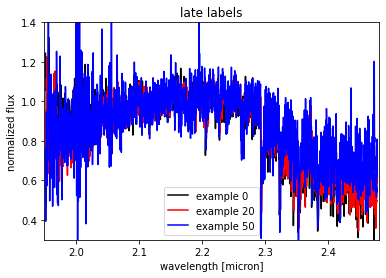

In [6]:
plt.plot(ressel[3],xsel[:,0],'-',color='black',label='example 0') 
plt.plot(ressel[3],xsel[:,20],'-',color='red',label='example 20') 
plt.plot(ressel[3],xsel[:,50],'-',color='blue',label='example 50')
plt.legend(loc="best")
plt.xlim(1.95,2.48)
plt.ylim(0.3,1.4)
plt.xlabel("wavelength [micron]")
plt.ylabel("normalized flux")
plt.title("late labels")

In [7]:
#getting row numners of unclassified and early
ids=np.arange(0,np.shape(xsel)[1],1)
print(f"unclassified examples {ids[np.where(veln[12]==0)]}")
print(f"early examples {ids[np.where(veln[12]==2)]}")


unclassified examples [ 256  258  442  448  449  450  454  456  460  471  498  508  517  519
  522  523  524  526  533  538  539  541 2762 2763 2774 2963 2975 2981
 3259 3972 3974 3990 3994 4008 4019 4059 4072 4081 4091 4124 4126 4127
 4140 4156 4164 4166 4174 4185 4191 4201 4221 4238 4240 4242 4243]
early examples [  12   14   40   66  108  114  176  184  228  334  428  453  592  673
  725  734 1873 2012 2251 2869 2936 2940 3853 3902 3957 4002 4056 4092
 4109 4110 4115 4199]


Text(0.5, 1.0, 'unclassified labels')

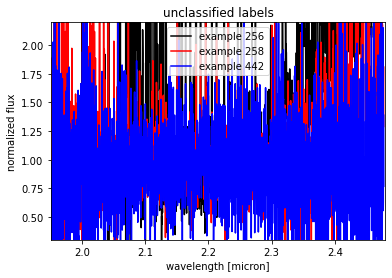

In [8]:
plt.plot(ressel[3],xsel[:,256],'-',color='black',label='example 256') 
plt.plot(ressel[3],xsel[:,258],'-',color='red',label='example 258') 
plt.plot(ressel[3],xsel[:,442],'-',color='blue',label='example 442')
plt.legend(loc="best")
plt.xlim(1.95,2.48)
plt.ylim(0.3,2.2)
plt.xlabel("wavelength [micron]")
plt.ylabel("normalized flux")
plt.title("unclassified labels")

Text(0.5, 1.0, 'early labels')

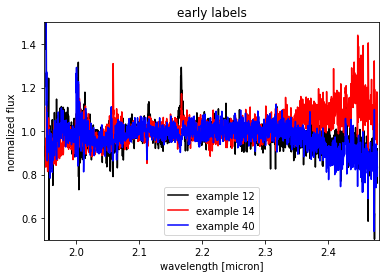

In [9]:
plt.plot(ressel[3],xsel[:,12],'-',color='black',label='example 12') 
plt.plot(ressel[3],xsel[:,14],'-',color='red',label='example 14') 
plt.plot(ressel[3],xsel[:,40],'-',color='blue',label='example 40')
plt.legend(loc="best")
plt.xlim(1.95,2.48)
plt.ylim(0.5,1.5)
plt.xlabel("wavelength [micron]")
plt.ylabel("normalized flux")
plt.title("early labels")

A relative large test set is used because not many sources are in the rare classes.

In [10]:
xsel_train, xsel_test, y_train, y_test, velg_train, velg_test  = train_test_split(np.transpose(xsel), veln[12], np.transpose(veln), test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2977, 2808)
shape of training labels (2977,)


We start with using the standard seetings of XCB classifier.

In [11]:
model1 = XGBClassifier()
model1.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Getting the predictions of test and training.

In [12]:
y_pred_train = model1.predict(xsel_train)
y_pred_test = model1.predict(xsel_test)


Because the sample is very unbalanced in labels, overall scores are not meaningful because they are dominated by the most common, easiest class. Instead by concentrate on the metrics of two rarest classes. First by look on the confusion matrixes.

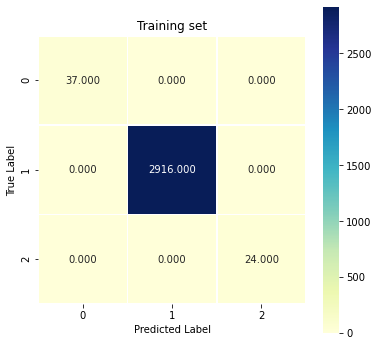

In [13]:
cm_nbtrain = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

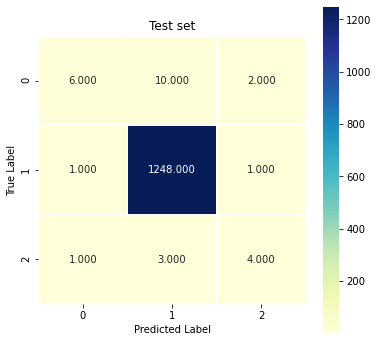

In [14]:
cm_nbtest = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [15]:
print(f"precision of early in training: {cm_nbtrain[2,2]/np.sum(cm_nbtrain[:,2])}")
print(f"recall of early in training: {cm_nbtrain[2,2]/np.sum(cm_nbtrain[2])}")
print(f"precision of unclassified in training: {cm_nbtrain[0,0]/np.sum(cm_nbtrain[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrain[0,0]/np.sum(cm_nbtrain[0])}")

print(f"precision of early in test: {cm_nbtest[2,2]/np.sum(cm_nbtest[:,2])}")
print(f"recall of early in test: {cm_nbtest[2,2]/np.sum(cm_nbtest[2])}")
print(f"precision of unclassified in test: {cm_nbtest[0,0]/np.sum(cm_nbtest[:,0])}")
print(f"recall of unclassified in test: {cm_nbtest[0,0]/np.sum(cm_nbtest[0])}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.5714285714285714
recall of early in test: 0.5
precision of unclassified in test: 0.75
recall of unclassified in test: 0.3333333333333333


In training the labels are perfectly predicted. In the test late is also qualified, only two truly late or predicted as different. In contrast, the prediction is less good for early and even more for unclassified. Especially, recall of unclassified is bad because the unclassified stars are wrongly classified because the class unclassfied as found by xgb is too narrow. That late is easiest is expected because late is the most abundant and most homogen class. Overall, the difference between test and tarining shows that there is overfitting. 

For counterimng overfitting the model needs to be changed. Given the few test samples best is a way with not too many free parameters. Therefore, I select subsample where there is only one parameter. 

In [16]:
model2 = XGBClassifier(subsample=0.5)
model2.fit(xsel_train, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [17]:
y2_pred_train = model2.predict(xsel_train)
y2_pred_test = model2.predict(xsel_test)

There are still all right in the training set and clearly less in test set. There is some improvemnt in the test set, especially for the unclassified.

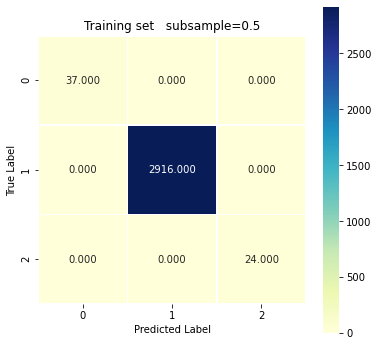

In [18]:
cm_nbtrain2 = confusion_matrix(y_train, y2_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set   subsample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

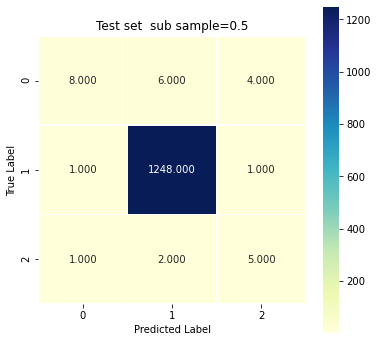

In [19]:
cm_nbtest2 = confusion_matrix(y_test, y2_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest2, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set  sub sample=0.5'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In [20]:
print(f"precision of early in training: {cm_nbtrain2[2,2]/np.sum(cm_nbtrain2[:,2])}")
print(f"recall of early in training: {cm_nbtrain2[2,2]/np.sum(cm_nbtrain2[2])}")
print(f"precision of unclassified in training: {cm_nbtrain2[0,0]/np.sum(cm_nbtrain2[:,0])}")
print(f"recall of unclassified in training: {cm_nbtrain2[0,0]/np.sum(cm_nbtrain2[0])}")

print(f"precision of early in test: {cm_nbtest2[2,2]/np.sum(cm_nbtest2[:,2])}")
print(f"recall of early in test: {cm_nbtest2[2,2]/np.sum(cm_nbtest2[2])}")
print(f"precision of unclassified in test: {cm_nbtest2[0,0]/np.sum(cm_nbtest2[:,0])}")
print(f"recall of unclassified in test: {cm_nbtest2[0,0]/np.sum(cm_nbtest2[0])}")

precision of early in training: 1.0
recall of early in training: 1.0
precision of unclassified in training: 1.0
recall of unclassified in training: 1.0
precision of early in test: 0.5
recall of early in test: 0.625
precision of unclassified in test: 0.8
recall of unclassified in test: 0.4444444444444444


In [95]:
#getting f1 score of one label xfrom confusing matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0:
        f1=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

To explore the subsample paramter more we run more models systematically.

In [22]:
#In ress the are summariyed using the F1 score. 
#First the f1 score of the current models early and unclassufied and their average 
ress=np.zeros((7,10))
ress[0,0]=1.0
ress[1,0]=fmeas(cm_nbtrain,int(2))
ress[2,0]=fmeas(cm_nbtrain,int(0))
ress[3,0]=(ress[1,0]+ress[2,0])/2
ress[4,0]=fmeas(cm_nbtest,int(2))
ress[5,0]=fmeas(cm_nbtest,int(0))
ress[6,0]=(ress[4,0]+ress[5,0])/2
ress[0,1]=0.5
ress[1,1]=fmeas(cm_nbtrain2,int(2))
ress[2,1]=fmeas(cm_nbtrain2,int(0))
ress[3,1]=(ress[1,1]+ress[2,1])/2
ress[4,1]=fmeas(cm_nbtest2,int(2))
ress[5,1]=fmeas(cm_nbtest2,int(0))
ress[6,1]=(ress[4,1]+ress[5,1])/2
#defining the further subsample values
ress[0,2]=0.33
ress[0,3]=0.2
ress[0,4]=0.14
ress[0,5]=0.1
ress[0,6]=0.07
ress[0,7]=0.05
ress[0,8]=0.04
ress[0,9]=0.03

In [23]:
#running for more subsample values
for i in range(2,10):
    print(i)
    print(f"subsample of {ress[0,i]}")
    model3 = XGBClassifier(subsample=ress[0,i])  
    model3.fit(xsel_train,y_train)
    y3_pred_train = model3.predict(xsel_train)
    y3_pred_test = model3.predict(xsel_test)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress[1,i]=fmeas(cm_nbtrain3,int(2))
    ress[2,i]=fmeas(cm_nbtrain3,int(0))
    ress[3,i]=(ress[1,i]+ress[2,i])/2
    ress[4,i]=fmeas(cm_nbtest3,int(2))
    ress[5,i]=fmeas(cm_nbtest3,int(0))
    ress[6,i]=(ress[4,i]+ress[5,i])/2

2
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3
subsample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4
subsample of 0.14


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5
subsample of 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
subsample of 0.07


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7
subsample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
8
subsample of 0.04


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9
subsample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<ipython-input-21-fb80d8345dd9>:5: RuntimeWarning: invalid value encountered in double_scalars
  f1=(2*prec*rec)/(prec+rec)


In training the score decreases continiously wuth subsample size. A sample of 0.03 leads no found early cases, because then usualy no examples are in a three. Unclassified performs still better in training in this case. In the test sample the evolution of the F1-score is usually smaller overall and it is noisy with up and downs. The optimum values is different for unclassified and early. Overall the score is rather flat. Large sumsample perform worse but between 0.04 0.33 there is no clear preferance, all achive about 0.6 as F1-score. 

Text(0, 0.5, 'F1-score')

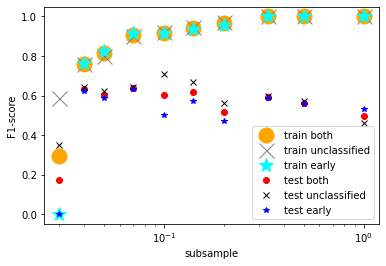

In [24]:
plt.plot(ress[0],ress[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress[0],ress[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress[0],ress[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress[0],ress[6],'o',color='red',label='test both') 
plt.plot(ress[0],ress[5],'x',color='black',label='test unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")

Using different weights for the classes should improve performance, but currently, it does not. It gets the same results
like means some coding is wrong. 

In [25]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
print(np.min(classes_weights))
print(np.max(classes_weights))

0.3403063557384545
41.34722222222222


In [26]:
xgb_classifier8 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier8.fit(xsel_train, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [27]:
y8_pred_train = xgb_classifier8.predict(xsel_train)
y8_pred_test = xgb_classifier8.predict(xsel_test)

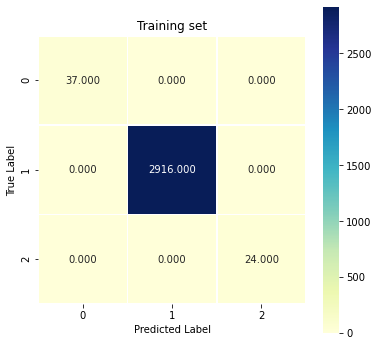

In [28]:
cm_nbtrain8 = confusion_matrix(y_train, y8_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

[[ 2  1 -3]
 [ 1 -3  2]
 [-1 -1  2]]


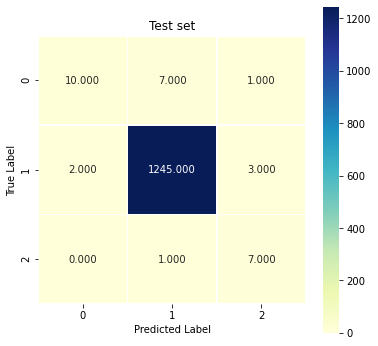

In [29]:
cm_nbtest8 = confusion_matrix(y_test, y8_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest8, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
print(cm_nbtest8-cm_nbtest2)  

Using weights in the fitting improves performance in the measures for the rare classes as it should be. The number of right classfication increases by two for both unclassified and early. In the late category 3 more are now qrong classified, but still 1345 of 1250 are correctly classified, clearly outweightung the wrong classifications. 

We now run weighted for all the same subsamples fraction as before. 

In [30]:
ress2=np.zeros((7,10))
ress2[0,:]=ress[0,:]
print(ress2[0,:])

[1.   0.5  0.33 0.2  0.14 0.1  0.07 0.05 0.04 0.03]


In [31]:
for i in range(10):
    print(f"sub sample of {ress2[0,i]}")
    xgb_classifier9 = xgb.XGBClassifier(subsample=ress2[0,i])
    xgb_classifier9.fit(xsel_train, y_train, sample_weight=classes_weights)
    y9_pred_train = xgb_classifier9.predict(xsel_train)
    y9_pred_test = xgb_classifier9.predict(xsel_test)
    cm_nbtrain9 = confusion_matrix(y_train, y9_pred_train)
    cm_nbtest9 = confusion_matrix(y_test, y9_pred_test)
    ress2[1,i]=fmeas(cm_nbtrain9,int(2))
    ress2[2,i]=fmeas(cm_nbtrain9,int(0))
    ress2[3,i]=(ress2[1,i]+ress2[2,i])/2
    ress2[4,i]=fmeas(cm_nbtest9,int(2))
    ress2[5,i]=fmeas(cm_nbtest9,int(0))
    ress2[6,i]=(ress2[4,i]+ress2[5,i])/2

sub sample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.14


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.07


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.04


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sub sample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Sub sample of 0.5 performs best for early and is also close to best for unclassified. In principle it still overfits the training data but when that is not anymore the care (below subsample of 0.1), the performance ob the test data is also worse.

Text(0.5, 1.0, 'weighted fits')

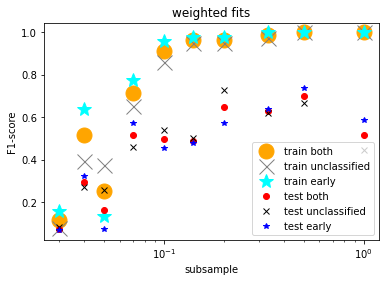

In [32]:
plt.plot(ress2[0],ress2[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress2[0],ress2[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress2[0],ress2[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress2[0],ress2[6],'o',color='red',label='test both') 
plt.plot(ress2[0],ress2[5],'x',color='black',label='test unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("weighted fits")

Text(0, 0.5, 'test F1-score')

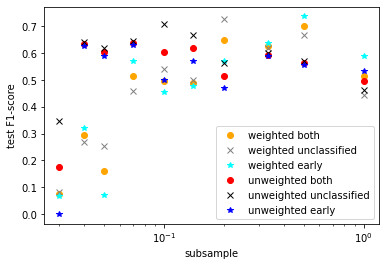

In [33]:
plt.plot(ress2[0],ress2[6],'o',color='orange',label='weighted both') 
plt.plot(ress2[0],ress2[5],'x',color='gray',label='weighted unclassified') 
plt.plot(ress2[0],ress2[4],'*',color='cyan',label='weighted early') 
plt.plot(ress[0],ress[6],'o',color='red',label='unweighted both') 
plt.plot(ress[0],ress[5],'x',color='black',label='unweighted unclassified') 
plt.plot(ress[0],ress[4],'*',color='blue',label='unweighted early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("test F1-score")

Intrinsic noisy (random variation between neighboring features) clearly affects the data is a a main reason for unclassified classifications. XGB has likely difficult to recognize that because the sample of unclassfied is too small that it can recognize it from the data. There now the noise is added as an additional feature. The noise is the standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.  

In [51]:
#the noise lvel is feature is currently in the general labels at 7
print(colnames[7])
print(f"noise is {velg_train[:,7]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise as feature
xsel_train2[:,np.shape(xsel_train)[1]]=velg_train[:,7]
xsel_test2[:,np.shape(xsel_test)[1]]=velg_test[:,7]

n/s
noise is [0.0160087  0.01839043 0.01425715 ... 0.00958813 0.00956729 0.00948825]
current feature shape of traing set is (2977, 2808)


Fit with subsample of 0.5 as in the best case before. 

In [52]:
model10 = XGBClassifier(subsample=0.5)
model10.fit(xsel_train2, y_train)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [53]:
y10_pred_train = model10.predict(xsel_train2)
y10_pred_test = model10.predict(xsel_test2)

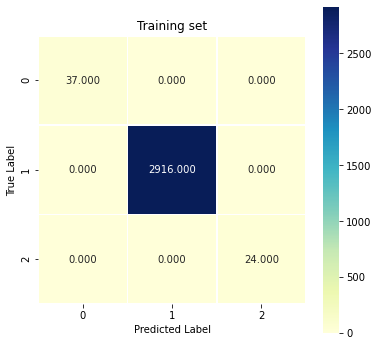

In [54]:
cm_nbtrain10 = confusion_matrix(y_train, y10_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

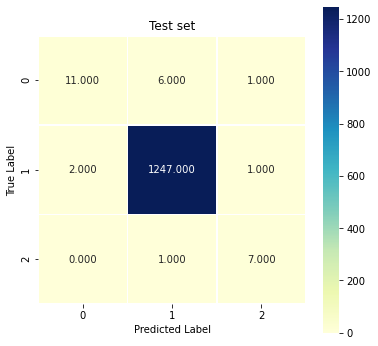

In [55]:
cm_nbtest10 = confusion_matrix(y_test, y10_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest10, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

The F1 score of early is better than all previous ones. The one of unclassified is also on the same level than the best ones before.
The average of the two is better than the best one before. 

In [63]:
print("all is for the test set")
print(f"F1-score unclassified {fmeas(cm_nbtest10,0)}")
print(f"best F1-score of unclassified before was {max(np.max(ress[5]),np.max(ress2[5]))}")
print(f"F1-score early {fmeas(cm_nbtest10,2)}")
print(f"best F1-score of early before was {max(np.max(ress[4]),np.max(ress2[4]))}")

all is for the test set
F1-score unclassified 0.7096774193548387
best F1-score of unclassified before was 0.7272727272727272
F1-score early 0.823529411764706
best F1-score of early before was 0.7368421052631579


Now also adding weights to fit. 

In [65]:
xgb_classifier11 = xgb.XGBClassifier(subsample=0.5)
xgb_classifier11.fit(xsel_train2, y_train, sample_weight=classes_weights)

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [66]:
y11_pred_train = xgb_classifier11.predict(xsel_train2)
y11_pred_test = xgb_classifier11.predict(xsel_test2)

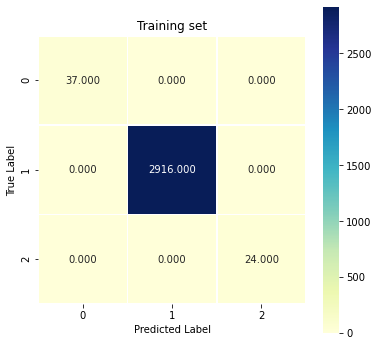

In [67]:
cm_nbtrain11 = confusion_matrix(y_train, y11_pred_train)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

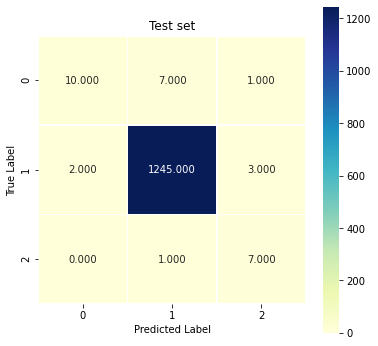

In [68]:
cm_nbtest11 = confusion_matrix(y_test, y11_pred_test)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest11, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

With the weights the classification does not improve even for the rare classes. As expected there is also worse classification of the late labelled ones.

In [70]:
print("all is for the test set")
print(f"F1-score unclassified unweighted {fmeas(cm_nbtest10,0)}")
print(f"F1-score unclassified weighted {fmeas(cm_nbtest11,0)}")
print(f"F1-score early unweighted {fmeas(cm_nbtest10,2)}")
print(f"F1-score early weighted {fmeas(cm_nbtest11,2)}")

all is for the test set
F1-score unclassified unweighted 0.7096774193548387
F1-score unclassified weighted 0.6666666666666667
F1-score early unweighted 0.823529411764706
F1-score early weighted 0.7368421052631579


Now we run unweighted with the additional noise label for the same sub sample values as before. 

In [102]:
ress3=np.zeros((7,10))
ress3[0,:]=ress[0,:]
for i in range(10):
    print(f"subsample of {ress3[0,i]}")
    model3 = XGBClassifier(subsample=ress3[0,i])  
    model3.fit(xsel_train2,y_train)
    y3_pred_train = model3.predict(xsel_train2)
    y3_pred_test = model3.predict(xsel_test2)
    cm_nbtrain3 = confusion_matrix(y_train, y3_pred_train)
    cm_nbtest3 = confusion_matrix(y_test, y3_pred_test)
    ress3[1,i]=fmeas(cm_nbtrain3,int(2))
    ress3[2,i]=fmeas(cm_nbtrain3,int(0))
    ress3[3,i]=(ress3[1,i]+ress3[2,i])/2
    ress3[4,i]=fmeas(cm_nbtest3,int(2))
    ress3[5,i]=fmeas(cm_nbtest3,int(0))
    ress3[6,i]=(ress3[4,i]+ress3[5,i])/2

subsample of 1.0


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.5


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.33


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.2


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.14


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.1


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.07


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.05


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.04


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
subsample of 0.03


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Sub sample of 0.5 is clearly the best sub sample of all for the test set. The values for the others are rather similar besides of the lowest one for 0.03.

Text(0.5, 1.0, 'noise an additional label')

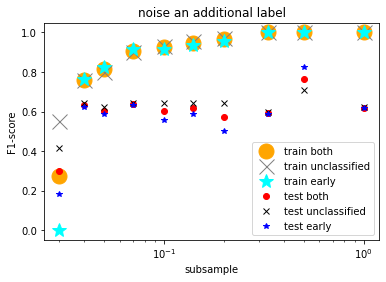

In [101]:
plt.plot(ress3[0],ress3[3],'o',ms=15,color='orange',label='train both') 
plt.plot(ress3[0],ress3[2],'x',ms=15,color='gray',label='train unclassified') 
plt.plot(ress3[0],ress3[1],'*',ms=15,color='cyan',label='train early') 
plt.plot(ress3[0],ress3[6],'o',color='red',label='test both') 
plt.plot(ress3[0],ress3[5],'x',color='black',label='test unclassified') 
plt.plot(ress3[0],ress3[4],'*',color='blue',label='test early') 
plt.legend(loc="best")
plt.xlabel("subsample")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise an additional label")

True